# TITANIC CHALLENGE

The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

This [challenge](https://www.kaggle.com/competitions/titanic/overview) asks to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

I'll try to address the problem with both a Machine Learning and a Deep Learning approach, searching for the best accuracy in the training set.

## 1. Load of Libraries

In [61]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os

## 2. Load of Train & Test data

`train data` and `test data` will be loaded in two separate dataframes. Since there will be some adjustments in the data, this is the best way to avoid any kind of contamination of `test data` with info from `train data` (e.g: replacing NaNs with median values taken from combined train and test datasets).

In [62]:
# Load of train data
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
train_data.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
PassengerId,891.0,NaN,NaN,NaN,446.0,257.353842,1.0,223.5,446.0,668.5,891.0
Survived,891.0,NaN,NaN,NaN,0.383838,0.486592,0.0,0.0,0.0,1.0,1.0
Pclass,891.0,NaN,NaN,NaN,2.308642,0.836071,1.0,2.0,3.0,3.0,3.0
Name,891,891,"Braund, Mr. Owen Harris",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sex,891,2,male,577,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,714.0,NaN,NaN,NaN,29.699118,14.526497,0.42,20.125,28.0,38.0,80.0
SibSp,891.0,NaN,NaN,NaN,0.523008,1.102743,0.0,0.0,0.0,1.0,8.0
Parch,891.0,NaN,NaN,NaN,0.381594,0.806057,0.0,0.0,0.0,0.0,6.0
Ticket,891,681,347082,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fare,891.0,NaN,NaN,NaN,32.204208,49.693429,0.0,7.9104,14.4542,31.0,512.3292


In [63]:
#Load of test data
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")
test_data.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
PassengerId,418.0,NaN,NaN,NaN,1100.5,120.810458,892.0,996.25,1100.5,1204.75,1309.0
Pclass,418.0,NaN,NaN,NaN,2.26555,0.841838,1.0,1.0,3.0,3.0,3.0
Name,418,418,"Kelly, Mr. James",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sex,418,2,male,266,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,332.0,NaN,NaN,NaN,30.27259,14.181209,0.17,21.0,27.0,39.0,76.0
SibSp,418.0,NaN,NaN,NaN,0.447368,0.89676,0.0,0.0,0.0,1.0,8.0
Parch,418.0,NaN,NaN,NaN,0.392344,0.981429,0.0,0.0,0.0,0.0,9.0
Ticket,418,363,PC 17608,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fare,417.0,NaN,NaN,NaN,35.627188,55.907576,0.0,7.8958,14.4542,31.5,512.3292
Cabin,91,76,B57 B59 B63 B66,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 3. EDA & Feature Engineering
Here are the features we can find in our datasets:

1. **Passenger ID**: ID associated to each passenger.
2. **Pclass**: The class each passenger belonged to. It is a categorical ordinal variable (1, 2 or 3)
3. **Name**: Name of each passenger, together with its title (e.g: Mr, Mrs, etc). It is a string.
3. **Sex**: Sex of each passenger. It's a categorical nominal variable ("male" or "female")
4. **Age**: Age of each passenger. It's a numerical variable (float, considering also babies with <1 year old)
5. **SibSp**: Number of sibilings of spouses. It's a numerical variable (int)
6. **Parch**: Number of parents or children. It's a numerical variable (int)
7. **Ticket**: Ticket code for each passenger. It's a string
8. **Fare**: Price of the ticket. It's a numerical variable (float)
9. **Cabin**: Code of the cabin for each passenger. It's a string.
10. **Embarked**: Where each passenger embarked. It's a categorical variable (`S` for Southampton, `C` for Cherbourg or `Q` for Queenstown)

We are going through each of those features, trying to figure out if they are related or not to Survival.

As first, we can state that `Passenger ID` is certainly not related to survival rate, thus we can drop it (we leave it in `test_data` since it will be needed for the final submission).

In [64]:
train_data = train_data.drop(['PassengerId'],axis=1)

## Pclass

Looking at the relationship between `Pclass` and `Survival`, `Pclass` seems an important feature to keep. One aspect to decide is whether keep it as it is or one-hot encode it.

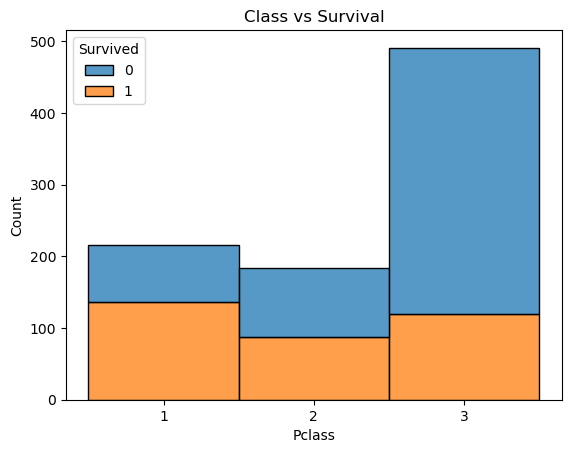

In [65]:
ax = sns.histplot(data=train_data,x='Pclass',hue='Survived',multiple='stack',discrete=True)
ax.set_xticks([1,2,3])
plt.title('Class vs Survival')
plt.show()

## Name

Names themselves seem not important in predicting survival rate. However, titles can be useful. Let's extact them and reorganize them (in order to group synonyms):

In [66]:
train_data['Title'] = train_data.Name.str.split(', ',expand=True)[1].str.split('.',expand=True)[0]
test_data['Title'] = test_data.Name.str.split(', ',expand=True)[1].str.split('.',expand=True)[0]

print(train_data['Title'].value_counts())
print(test_data['Title'].value_counts())

# Conversion of "Mlle" title in "Miss". This is done outside the function since there is no info about the marital status of passengers in other features
train_data['Title'] = train_data['Title'].replace('Mlle','Miss')
test_data['Title'] = test_data['Title'].replace('Mlle','Miss')

# Function that convert generic Titles in the main four categories allowed
def rename_titles(df, allowed):
    for i in range(len(df)):
        if df['Title'][i] not in allowed:
            if df['Sex'][i] == 'male':
                if df['Age'][i] >= 18:
                    df['Title'][i] = 'Mr'
                else:
                    df['Title'][i] = 'Master'
            else:
                df['Title'][i] = 'Mrs'
    return df['Title']

allowed = ['Mr','Miss','Mrs','Master']

train_data['Title'] = rename_titles(train_data, allowed)
test_data['Title'] = rename_titles(test_data, allowed)

print(train_data['Title'].value_counts())
print(test_data['Title'].value_counts())

train_data = train_data.drop(['Name'],axis=1)
test_data = test_data.drop(['Name'],axis=1)

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
the Countess      1
Capt              1
Ms                1
Sir               1
Lady              1
Mme               1
Don               1
Jonkheer          1
Name: Title, dtype: int64
Mr        240
Miss       78
Mrs        72
Master     21
Col         2
Rev         2
Ms          1
Dr          1
Dona        1
Name: Title, dtype: int64
Mr        536
Miss      184
Mrs       130
Master     41
Name: Title, dtype: int64
Mr        245
Miss       78
Mrs        74
Master     21
Name: Title, dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Looking at the correlation between `Title` and `Survived`, it seems that `Title` could be a useful feature:

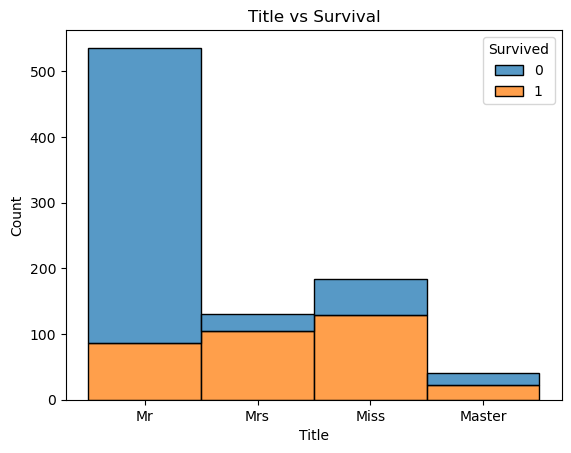

In [67]:
sns.histplot(data=train_data,x='Title',hue='Survived',multiple='stack',discrete=True)
plt.title('Title vs Survival')
plt.show()

## Sex

`Sex` seems definitely an important feature. Nevertheless, it could have an high correlation with `Title` feature. For now, let's keep it.

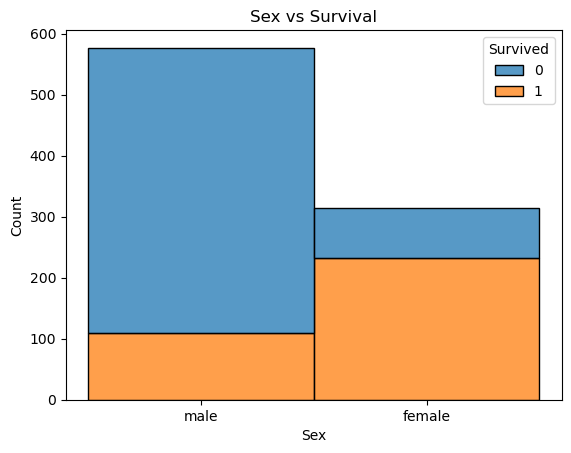

In [68]:
sns.histplot(data=train_data,x='Sex',hue='Survived',multiple='stack',discrete=True)
plt.title('Sex vs Survival')
plt.show()

## Age

`Age` has a lot of NaN, which can be replaced with the median value for each `Title` group:

In [69]:
# Train data
age_median_mr = train_data[train_data['Title']=='Mr'].Age.median()
age_median_master = train_data[train_data['Title']=='Master'].Age.median()
age_median_mrs = train_data[train_data['Title']=='Mrs'].Age.median()
age_median_miss = train_data[train_data['Title']=='Miss'].Age.median()

nan_count = train_data['Age'].isnull()
for i in range(len(train_data)):
    if nan_count[i]:
        if train_data.at[i,'Title'] == 'Mr':
            train_data.at[i,'Age'] = age_median_mr
        elif train_data.at[i,'Title'] == 'Master':
            train_data.at[i,'Age'] = age_median_master
        elif train_data.at[i,'Title'] == 'Mrs':
            train_data.at[i,'Age'] = age_median_mrs
        else:
            train_data.at[i,'Age'] = age_median_miss
            
# Test data
age_median_mr = test_data[test_data['Title']=='Mr'].Age.median()
age_median_master = test_data[test_data['Title']=='Master'].Age.median()
age_median_mrs = test_data[test_data['Title']=='Mrs'].Age.median()
age_median_miss = test_data[test_data['Title']=='Miss'].Age.median()
            
nan_count = test_data['Age'].isnull()
for i in range(len(test_data)):
    if nan_count[i]:
        if test_data.at[i,'Title'] == 'Mr':
            test_data.at[i,'Age'] = age_median_mr
        elif test_data.at[i,'Title'] == 'Master':
            test_data.at[i,'Age'] = age_median_master
        elif test_data.at[i,'Title'] == 'Mrs':
            test_data.at[i,'Age'] = age_median_mrs
        else:
            test_data.at[i,'Age'] = age_median_miss

Looking at the Age-Survival distribution, seems that Age could be an important feature:

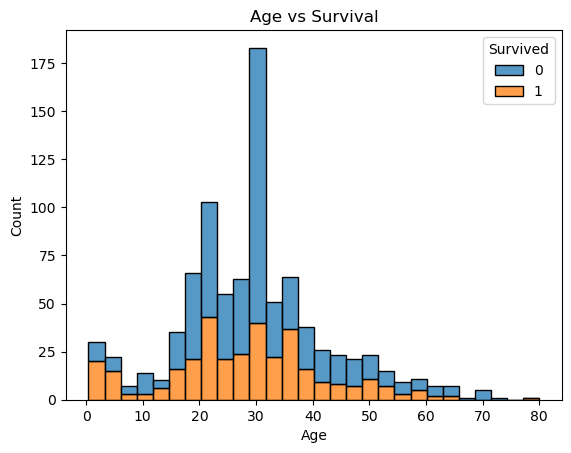

In [70]:
sns.histplot(data=train_data,x='Age',hue='Survived',multiple='stack')
plt.title('Age vs Survival')
plt.show()

Can be useful also to create a variable that groups up ages in ranges of 10 years:

In [71]:
age_labels=['0-9','10-19','20-29','30-39','40-49','50-59','60-69','70-80']
train_data['Age_ranges'] = pd.cut(train_data.Age, bins = 8, labels=age_labels)
test_data['Age_ranges'] = pd.cut(test_data.Age, bins = 8, labels=age_labels)

## SibSp & Parch

Looking at the distribution of the survival rate for `SibSp` and `Parch` features, we can see that almost 2/3 of the passengers with no relatives (`SibSp` = 0 or `Parch` = 0) did not survive. Seems useful then to discriminate just between 0 and not 0 values.

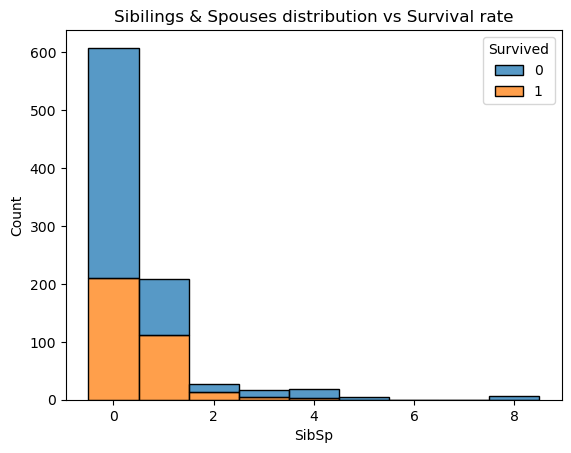

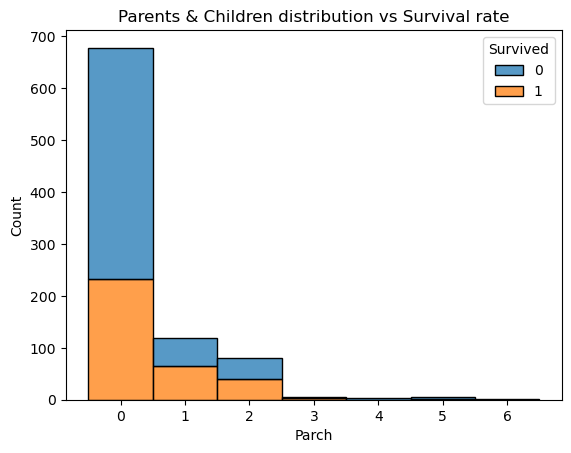

In [72]:
# Let's plot the "SibSp" and "Parch" distribution
sns.histplot(data=train_data, x='SibSp', hue='Survived',multiple='stack',discrete=True)
plt.title('Sibilings & Spouses distribution vs Survival rate')
plt.show()
plt.clf()
sns.histplot(data=train_data, x='Parch', hue='Survived',multiple='stack',discrete=True)
plt.title('Parents & Children distribution vs Survival rate')
plt.show()

Let's check if this result holds when combining the two features:

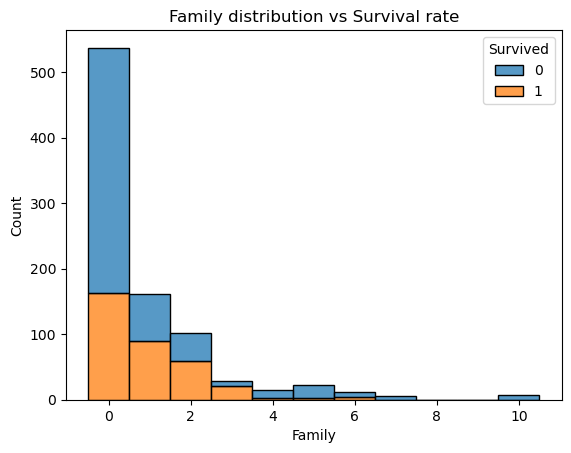

In [73]:
train_data['Family']=train_data['SibSp'] + train_data['Parch']
sns.histplot(data=train_data, x='Family', hue='Survived',multiple='stack',discrete=True)
plt.title('Family distribution vs Survival rate')
plt.show()

With the features combined it's even more relevant the difference. A difference (in favour of Survival) can be seen also with values of `Family` from 1 to 3. 

Let's create features `has_SibSp`, `has_Parch` and `Alone` which discriminate 0 from non-0 values

In [74]:
test_data['Family']=test_data['SibSp'] + test_data['Parch']

# Make those variables boolean
train_data['has_SibSp'] = train_data['SibSp'].apply(lambda x: 0 if x==0 else 1)
train_data['has_Parch'] = train_data['Parch'].apply(lambda x: 0 if x==0 else 1)
train_data['Alone'] = train_data['Family'].apply(lambda x: 1 if x==0 else 0)

test_data['has_SibSp'] = test_data['SibSp'].apply(lambda x: 0 if x==0 else 1)
test_data['has_Parch'] = test_data['Parch'].apply(lambda x: 0 if x==0 else 1)
test_data['Alone'] = test_data['Family'].apply(lambda x: 1 if x==0 else 0)

## Ticket

`Ticket` feature has 681 unique values. Values that are not unique are usually associated to families, which are already addressed by features `Family`, `has_SibSp`, `has_Parch` and `Alone`. Seems thus quite difficult to handle (there is not a pattern which can be used to group tickets) and not particularly relevant in defining the survival rate. We can drop it.

In [75]:
ticket_count = train_data['Ticket'].value_counts()
print(ticket_count[ticket_count>2])

train_data = train_data.drop(['Ticket'],axis=1)
test_data = test_data.drop(['Ticket'],axis=1)

347082           7
CA. 2343         7
1601             7
3101295          6
CA 2144          6
347088           6
S.O.C. 14879     5
382652           5
LINE             4
PC 17757         4
17421            4
349909           4
113760           4
4133             4
113781           4
W./C. 6608       4
2666             4
19950            4
347077           4
C.A. 31921       3
PC 17572         3
C.A. 34651       3
363291           3
F.C.C. 13529     3
345773           3
248727           3
24160            3
29106            3
SC/Paris 2123    3
35273            3
371110           3
230080           3
PC 17760         3
239853           3
PC 17582         3
347742           3
110152           3
13502            3
110413           3
PC 17755         3
Name: Ticket, dtype: int64


## Fare

First of all, let's see if there are cases with `Fare = 0` and replace them with the median value of `Fare` referred to each `Pclass` (median value since the distribution is not normal).

In [76]:
# Let's count how many Fares are =0, and replace them with the median value of Fare (according to each PClass)
print(train_data[train_data['Fare']==0][['Pclass','Fare','Age']])

print(train_data['Fare'].iloc[179])
print(train_data['Fare'].iloc[263])
print(train_data['Fare'].iloc[277])

     Pclass  Fare   Age
179       3   0.0  36.0
263       1   0.0  40.0
271       3   0.0  25.0
277       2   0.0  30.0
302       3   0.0  19.0
413       2   0.0  30.0
466       2   0.0  30.0
481       2   0.0  30.0
597       3   0.0  49.0
633       1   0.0  30.0
674       2   0.0  30.0
732       2   0.0  30.0
806       1   0.0  39.0
815       1   0.0  30.0
822       1   0.0  38.0
0.0
0.0
0.0


In [77]:
# Replace 0 values with the mean value, according to Pclass
fare_median_1 = np.round(train_data[train_data['Pclass'] == 1].Fare.median(),4)
fare_median_2 = np.round(train_data[train_data['Pclass'] == 2].Fare.median(),4)
fare_median_3 = np.round(train_data[train_data['Pclass'] == 3].Fare.median(),4)

for i in range(len(train_data)):
    if train_data.at[i,'Fare'] == 0.0:
        if train_data.at[i,'Pclass'] == 1:
            train_data.at[i,'Fare'] = fare_median_1
        elif train_data.at[i,'Pclass'] == 2:
            train_data.at[i,'Fare'] = fare_median_2
        elif train_data.at[i,'Pclass'] == 3:
            train_data.at[i,'Fare'] = fare_median_3
            
print(train_data['Fare'].iloc[179])
print(train_data['Fare'].iloc[263])
print(train_data['Fare'].iloc[277])

#Let's do the same with test_data

fare_test_median_1 = np.round(test_data[test_data['Pclass'] == 1].Fare.median(),4)
fare_test_median_2 = np.round(test_data[test_data['Pclass'] == 2].Fare.median(),4)
fare_test_median_3 = np.round(test_data[test_data['Pclass'] == 3].Fare.median(),4)

for i in range(len(test_data)):
    if test_data.at[i,'Fare'] == 0.0:
        if test_data.at[i,'Pclass'] == 1:
            test_data.at[i,'Fare'] = fare_test_median_1
        elif test_data.at[i,'Pclass'] == 2:
            test_data.at[i,'Fare'] = fare_test_median_2
        elif test_data.at[i,'Pclass'] == 3:
            test_data.at[i,'Fare'] = fare_test_median_3
            
print(fare_test_median_1)
print(fare_test_median_2)
print(fare_test_median_3)

8.05
60.2875
14.25
60.0
15.75
7.8958


In `test_data` there is 1 `NaN` in `Fare`. Let's replace it according to its `Pclass`

In [78]:
print(test_data[test_data.Fare.isna()])
test_data.Fare.fillna(fare_test_median_3,inplace=True)

     PassengerId  Pclass   Sex   Age  SibSp  Parch  Fare Cabin Embarked Title  \
152         1044       3  male  60.5      0      0   NaN   NaN        S    Mr   

    Age_ranges  Family  has_SibSp  has_Parch  Alone  
152      60-69       0          0          0      1  


Looking at the distribution of Fares and their relationship with survival rate, it seems that `Fare` could be an important feature.

The distribution is highly right-skewed, thus we can think of converting it to log scale (in order to normalize it)

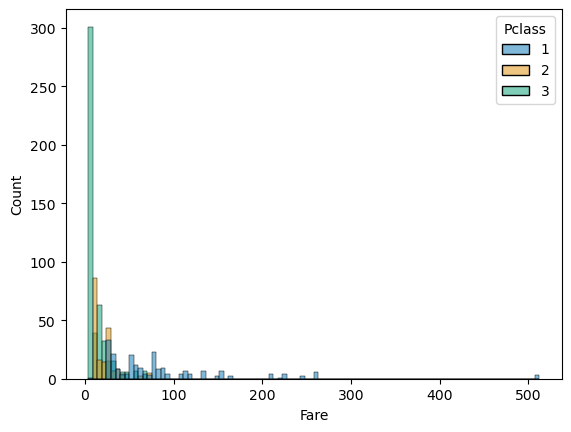

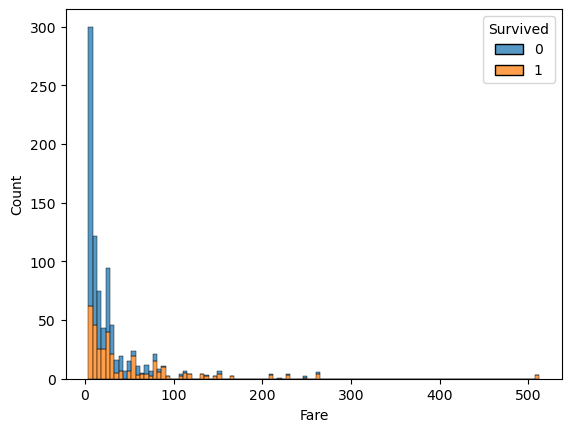

In [79]:
sns.histplot(data=train_data,x='Fare',hue='Pclass',bins=100, palette='colorblind')
plt.show()
plt.clf()

sns.histplot(data=train_data,x='Fare',hue='Survived',multiple='stack')
plt.show()

In [80]:
# Log conversion of fare
train_data['log_Fare'] = np.log(train_data['Fare'])
test_data['log_Fare'] = np.log(test_data['Fare'])


## Cabin

At a first look, `Cabin` seems a good candidate for removal (due to the huge amount of NaN). However, following [Miguel Vela](https://www.kaggle.com/code/miguelvela/the-titanic-in-a-random-forest) approach, we can retrieve some information about the Deck of each Cabin that could be useful

In [81]:
train_data['Deck'] = train_data.Cabin.str[0]
test_data['Deck'] = test_data.Cabin.str[0]

train_data = train_data.drop(['Cabin'],axis=1)
test_data = test_data.drop(['Cabin'],axis=1)

print(train_data.Deck.value_counts())
print(test_data.Deck.value_counts())

C    59
B    47
D    33
E    32
A    15
F    13
G     4
T     1
Name: Deck, dtype: int64
C    35
B    18
D    13
E     9
F     8
A     7
G     1
Name: Deck, dtype: int64


`NaN` can be associated to the "Unknown" Deck `U`. Also Deck `T`, which appears only once in train_data, is included in `U`.

In [82]:
train_data.Deck.fillna('U', inplace=True)
test_data.Deck.fillna('U',inplace=True)
train_data.Deck.replace('T','U',inplace=True)

print(train_data.Deck.value_counts())
print(test_data.Deck.value_counts())

U    688
C     59
B     47
D     33
E     32
A     15
F     13
G      4
Name: Deck, dtype: int64
U    327
C     35
B     18
D     13
E      9
F      8
A      7
G      1
Name: Deck, dtype: int64


Looking at the survival rate for each Deck, indeed this feature could be useful in the analysis.

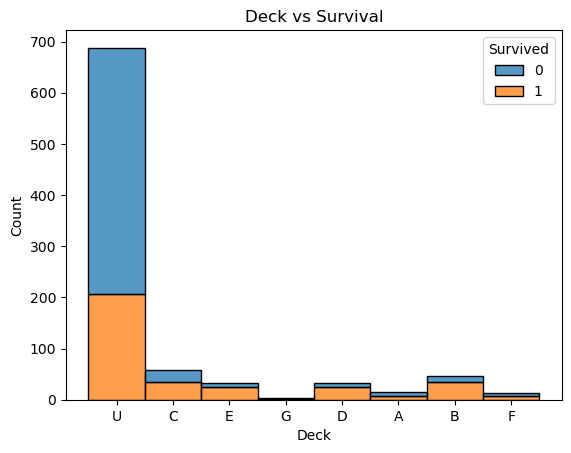

Deck  Survived
A     0           0.533333
      1           0.466667
B     1           0.744681
      0           0.255319
C     1           0.593220
      0           0.406780
D     1           0.757576
      0           0.242424
E     1           0.750000
      0           0.250000
F     1           0.615385
      0           0.384615
G     0           0.500000
      1           0.500000
U     0           0.700581
      1           0.299419
Name: Survived, dtype: float64


In [83]:
sns.histplot(data=train_data,x='Deck',hue='Survived',multiple='stack',discrete=True,common_norm=True)
plt.title('Deck vs Survival')
plt.show()

print(train_data.groupby('Deck').Survived.value_counts(normalize=True))

## Embarked

`NaN` values can be replaced with the most frequent value both in `train_data` and in `test_data`. Looking at the distribution, this feature must be kept.

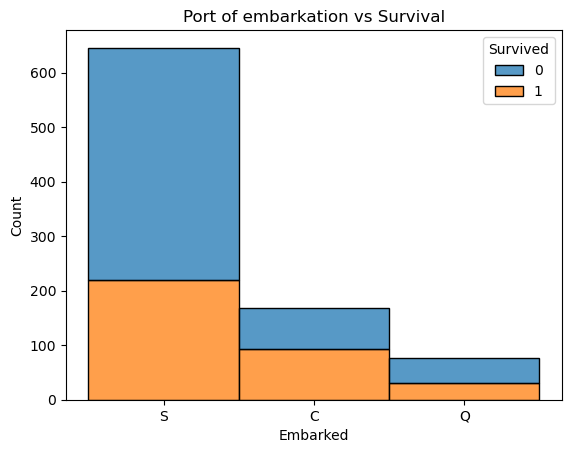

Embarked  Survived
C         1           0.553571
          0           0.446429
Q         0           0.610390
          1           0.389610
S         0           0.660991
          1           0.339009
Name: Survived, dtype: float64


In [84]:
# NaNs can be replaced with value_counts().idxmax() method
train_data.fillna({'Embarked': train_data['Embarked'].value_counts().idxmax()},inplace=True)
test_data.fillna({'Embarked': test_data['Embarked'].value_counts().idxmax()},inplace=True)

sns.histplot(data=train_data,x='Embarked',hue='Survived',multiple='stack',discrete=True)
plt.title('Port of embarkation vs Survival')
plt.show()

print(train_data.groupby('Embarked').Survived.value_counts(normalize=True))

## One-hot encoding and Scaling

Let's look at our dataframe, in order to understand which feature must be Scaled, which one must be hot-encoded, etc.:

In [85]:
train_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Age_ranges,Family,has_SibSp,has_Parch,Alone,log_Fare,Deck
0,0,3,male,22.0,1,0,7.2500,S,Mr,20-29,1,1,0,0,1.981001,U
1,1,1,female,38.0,1,0,71.2833,C,Mrs,30-39,1,1,0,0,4.266662,C
2,1,3,female,26.0,0,0,7.9250,S,Miss,20-29,0,0,0,1,2.070022,U
3,1,1,female,35.0,1,0,53.1000,S,Mrs,30-39,1,1,0,0,3.972177,C
4,0,3,male,35.0,0,0,8.0500,S,Mr,30-39,0,0,0,1,2.085672,U


In [86]:
train_data.describe(include='all')

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Age_ranges,Family,has_SibSp,has_Parch,Alone,log_Fare,Deck
count,891.000000,891.000000,891,891.000000,891.000000,891.000000,891.000000,891,891,891,891.000000,891.000000,891.000000,891.000000,891.000000,891
unique,NaN,NaN,2,NaN,NaN,NaN,NaN,3,4,8,NaN,NaN,NaN,NaN,NaN,8
top,NaN,NaN,male,NaN,NaN,NaN,NaN,S,Mr,20-29,NaN,NaN,NaN,NaN,NaN,U
freq,NaN,NaN,577,NaN,NaN,NaN,NaN,646,536,385,NaN,NaN,NaN,NaN,NaN,688
mean,0.383838,2.308642,NaN,29.341942,0.523008,0.381594,32.674620,NaN,NaN,NaN,0.904602,0.317621,0.239057,0.602694,2.944103,NaN
std,0.486592,0.836071,NaN,13.281214,1.102743,0.806057,49.608084,NaN,NaN,NaN,1.613459,0.465813,0.426747,0.489615,0.934672,NaN
min,0.000000,1.000000,NaN,0.420000,0.000000,0.000000,4.012500,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,1.389414,NaN
25%,0.000000,2.000000,NaN,21.000000,0.000000,0.000000,7.925000,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,2.070022,NaN
50%,0.000000,3.000000,NaN,30.000000,0.000000,0.000000,14.500000,NaN,NaN,NaN,0.000000,0.000000,0.000000,1.000000,2.674149,NaN
75%,1.000000,3.000000,NaN,35.000000,1.000000,0.000000,31.275000,NaN,NaN,NaN,1.000000,1.000000,0.000000,1.000000,3.442819,NaN


The following features can be one-hot encoded:

- Sex
- Embarked
- Title
- Deck
- Age_ranges

In [88]:
train_data = pd.get_dummies(train_data,drop_first=True)
print(train_data2.columns)
test_data = pd.get_dummies(test_data,drop_first=True)


Index(['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Family',
       'has_SibSp', 'has_Parch', 'Alone', 'Sex_male', 'Embarked_Q',
       'Embarked_S', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Deck_B', 'Deck_C',
       'Deck_D', 'Deck_E', 'Deck_F', 'Deck_G', 'Deck_U', 'Age_ranges_10-19',
       'Age_ranges_20-29', 'Age_ranges_30-39', 'Age_ranges_40-49',
       'Age_ranges_50-59', 'Age_ranges_60-69', 'Age_ranges_70-80'],
      dtype='object')


In [89]:
continuous = ['Age', 'Fare', 'log_Fare']

scaler = StandardScaler()

train_data_scaled = train_data
test_data_scaled = test_data
for var in continuous:
    train_data_scaled[var] = train_data[var].astype('float64')
    train_data_scaled[var] = scaler.fit_transform(train_data_scaled[var].values.reshape(-1, 1))
    test_data_scaled[var] = test_data[var].astype('float64')
    test_data_scaled[var] = scaler.fit_transform(test_data_scaled[var].values.reshape(-1, 1))

print(train_data_scaled.head())
print(test_data_scaled.head())

   Survived  Pclass       Age  SibSp  Parch      Fare  Family  has_SibSp  \
0         0       3 -0.553117      1      0 -0.512797       1          1   
1         1       1  0.652269      1      0  0.778711       1          1   
2         1       3 -0.251771      0      0 -0.499183       0          0   
3         1       1  0.426259      1      0  0.411966       1          1   
4         0       3  0.426259      0      0 -0.496662       0          0   

   has_Parch  Alone  ...  Age_ranges_50-59  Age_ranges_60-69  \
0          0      0  ...                 0                 0   
1          0      0  ...                 0                 0   
2          0      1  ...                 0                 0   
3          0      0  ...                 0                 0   
4          0      1  ...                 0                 0   

   Age_ranges_70-80  Deck_B  Deck_C  Deck_D  Deck_E  Deck_F  Deck_G  Deck_U  
0                 0       0       0       0       0       0       0       1  
1 

To avoid collinearity, let's check the correlation between each feature in a heatmap:

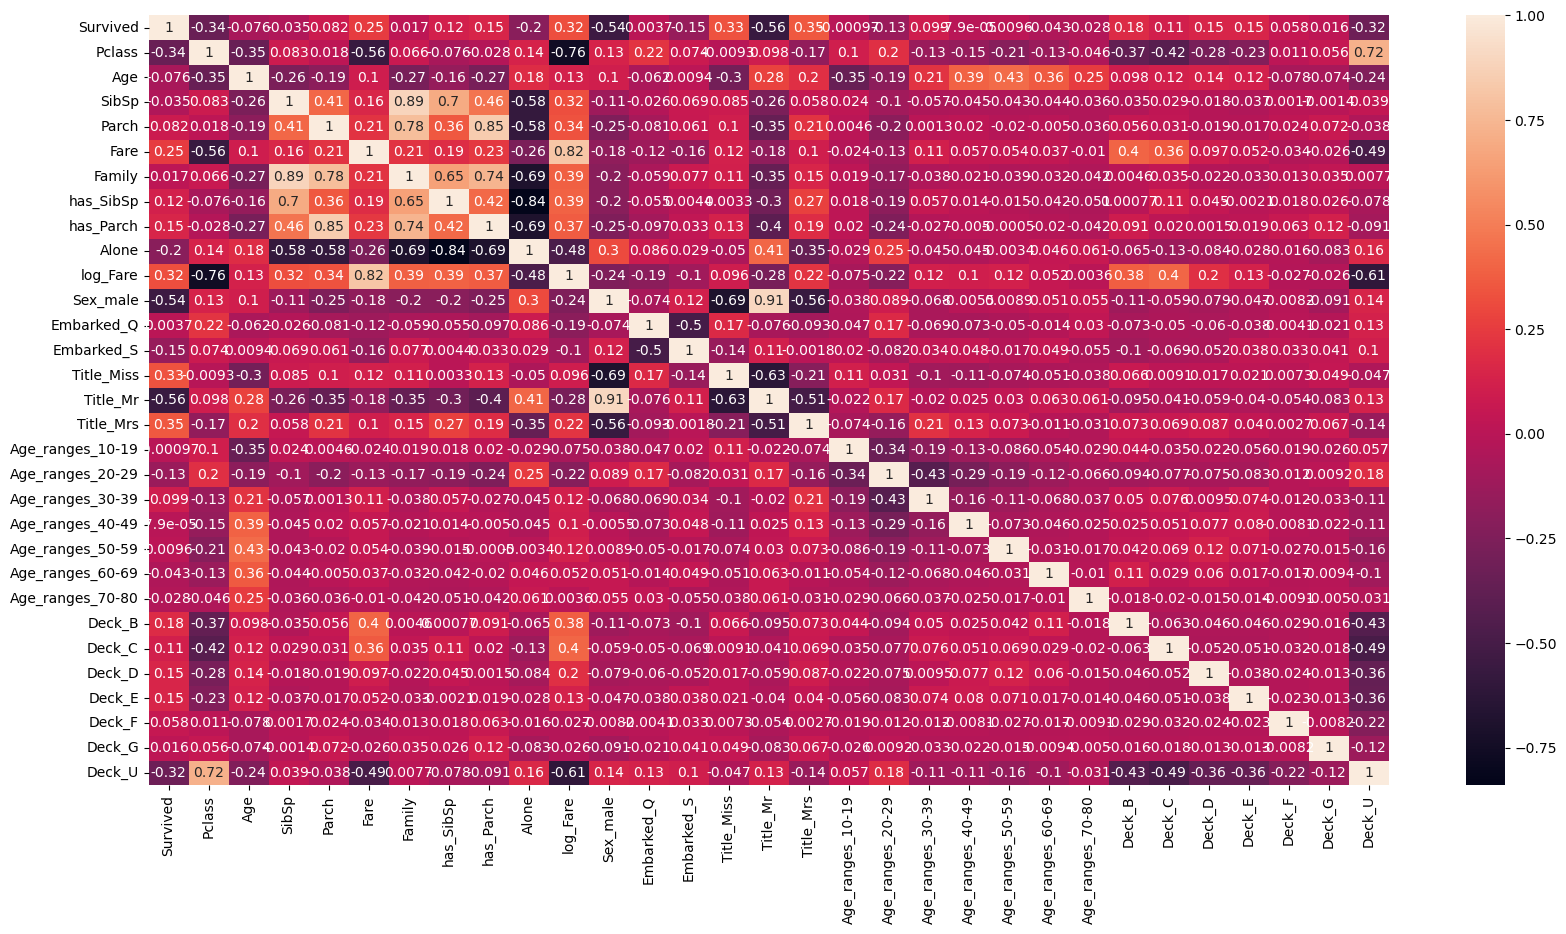

<Figure size 640x480 with 0 Axes>

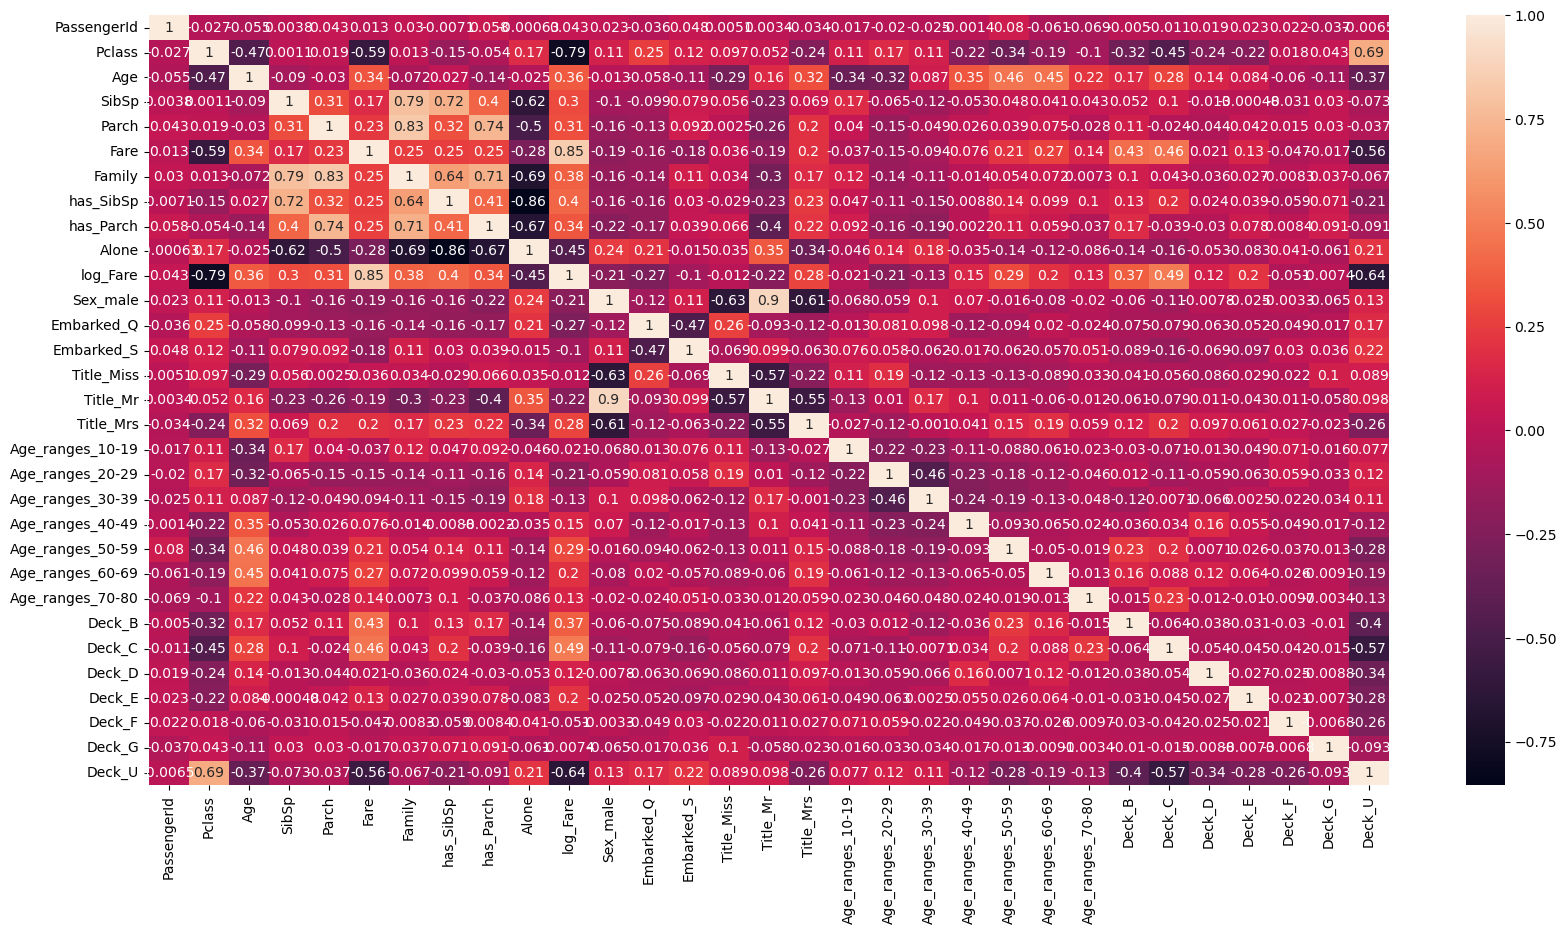

In [98]:
train_corrs = train_data_scaled.corr()
test_corrs = test_data_scaled.corr()

plt.figure(figsize=(20,10))
sns.heatmap(train_corrs, annot=True)
plt.show()
plt.clf()

plt.figure(figsize=(20,10))
sns.heatmap(test_corrs, annot=True)
plt.show()

As predictable, `Family`, `Parch`, `SibSp`, `has_SibSp`, `has_Parch` and `Alone` are quite correlated among them. Also, `Pclass` is related to `log_Fare` and `Sex_male` is of course related to `Mr`. When creating the `X` dataframe, those features must be mutually exclusive, in particular those whose correlation value is > 0.7.

Let's save in variable `y` the labels and in variable `X` the features we want to investigate with ML models, and split `X` and `y` in train and test data (to avoid confusion, we also rename `test_data` to `X_validation`):

In [177]:
# Total Features 
#'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Family',
#'has_SibSp', 'has_Parch', 'Alone', 'log_Fare', 'Sex_male', 'Embarked_Q',
#'Embarked_S', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Deck_B', 'Deck_C',
#'Deck_D', 'Deck_E', 'Deck_F', 'Deck_G', 'Deck_U', 'Age_ranges_10-19',
#'Age_ranges_20-29', 'Age_ranges_30-39', 'Age_ranges_40-49',
#'Age_ranges_50-59', 'Age_ranges_60-69', 'Age_ranges_70-80']

features_selected = ['Pclass', 'has_SibSp', 'has_Parch', 'Family', 'Age', 'Fare', 'Embarked_Q',
       'Embarked_S', 'Title_Mr', 'Deck_B', 'Deck_C',
       'Deck_D', 'Deck_E', 'Deck_F', 'Deck_G', 'Deck_U']

y = train_data_scaled["Survived"]
X = train_data_scaled[features_selected]
X_validation = test_data_scaled[features_selected]
X_train_scaled,X_test_scaled,y_train,y_test = train_test_split(X,y,test_size = 0.33, random_state=42)

print(X_train_scaled.head())

     Pclass  has_SibSp  has_Parch  Family       Age      Fare  Embarked_Q  \
6         1          0          0       0  1.857654  0.387007           0   
718       3          0          0       0  0.049576 -0.346401           1   
685       2          1          1       3 -0.327107  0.179599           0   
73        3          1          0       1 -0.251771 -0.367494           0   
882       3          0          0       0 -0.553117 -0.446910           0   

     Embarked_S  Title_Mr  Deck_B  Deck_C  Deck_D  Deck_E  Deck_F  Deck_G  \
6             1         1       0       0       0       1       0       0   
718           0         1       0       0       0       0       0       0   
685           0         1       0       0       0       0       0       0   
73            0         1       0       0       0       0       0       0   
882           1         0       0       0       0       0       0       0   

     Deck_U  
6         0  
718       1  
685       1  
73        1  
882 

## 4. Run of several ML models

### Logistic Regression

In [172]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train_scaled,y_train)

# Score the model on the test data
print(lr.score(X_test_scaled,y_test))

0.8372881355932204


### Random Forest

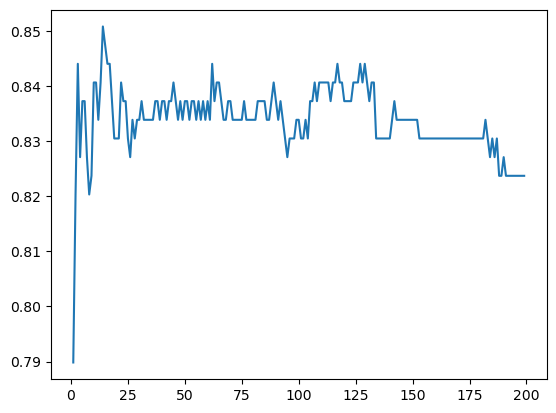

0.8508474576271187
13
0.8508474576271187
[0.16569202 0.00070134 0.01729538 0.04233554 0.05246172 0.07912331
 0.00226988 0.05223642 0.45214181 0.         0.00209126 0.00317003
 0.02832607 0.         0.00298032 0.0991749 ]
Your submission was successfully saved!


In [178]:
from sklearn.ensemble import RandomForestClassifier

scores_forest=[]
for k in range(1,200):
    forest = RandomForestClassifier(n_estimators=k, max_depth=3, random_state=42)
    forest.fit(X_train_scaled, y_train)
    #predictions = model.predict(X_test)
    scores_forest.append(forest.score(X_test_scaled,y_test))

plt.plot(range(1,200),scores_forest)
plt.show()

print(np.max(scores_forest))
print(np.argmax(scores_forest))


model = RandomForestClassifier(n_estimators=14, max_depth=3, random_state=42)
model.fit(X_train_scaled, y_train)
print(model.score(X_test_scaled,y_test))
print(model.feature_importances_)

predictions = model.predict(X_validation)

output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('submission_rf_14_3.csv', index=False)
print("Your submission was successfully saved!")

### Gradient Boosting

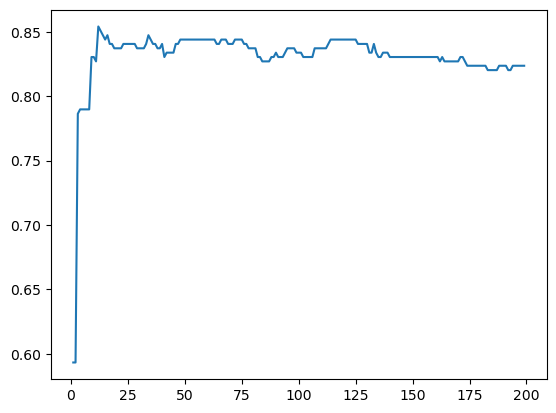

0.8542372881355932
11
0.8542372881355932
[0.21774885 0.         0.         0.01138758 0.01929381 0.09773018
 0.         0.01858138 0.57685193 0.         0.00269535 0.00409705
 0.01741658 0.         0.         0.03419729]


'predictions = grad_classifier.predict(X_validation_scaled)\n\noutput = pd.DataFrame({\'PassengerId\': test_data.PassengerId, \'Survived\': predictions})\noutput.to_csv(\'submission_grad.csv\', index=False)\nprint("Your submission was successfully saved!")'

In [174]:
from sklearn.ensemble import GradientBoostingClassifier

scores_grad=[]
for k in range(1,200):
    grad_classifier = GradientBoostingClassifier(n_estimators=k, random_state=42)
    grad_classifier.fit(X_train_scaled,y_train)
    scores_grad.append(grad_classifier.score(X_test_scaled,y_test))

plt.plot(range(1,200),scores_grad)
plt.show()

print(np.max(scores_grad))
print(np.argmax(scores_grad))

grad_classifier = GradientBoostingClassifier(n_estimators=12)
grad_classifier.fit(X_train_scaled,y_train)
print(grad_classifier.score(X_test_scaled,y_test))
print(grad_classifier.feature_importances_)

"""predictions = grad_classifier.predict(X_validation_scaled)

output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('submission_grad.csv', index=False)
print("Your submission was successfully saved!")"""

### SVM

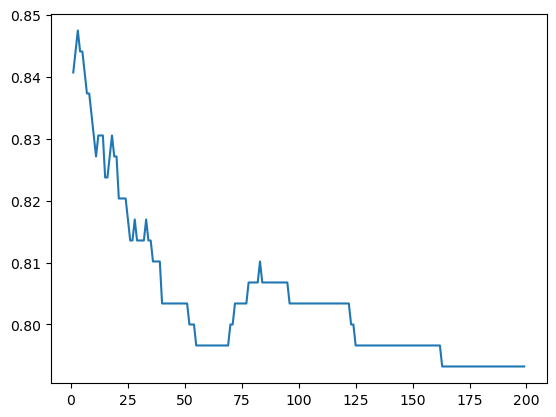

0.847457627118644
2
0.8440677966101695


'predictions = svm.predict(X_validation_scaled)\n\noutput = pd.DataFrame({\'PassengerId\': test_data.PassengerId, \'Survived\': predictions})\noutput.to_csv(\'submission_svm.csv\', index=False)\nprint("Your submission was successfully saved!")'

In [175]:
from sklearn.svm import SVC

scores_svm = []
for c in range(1,200):
    svm = SVC(C=c, random_state = 42)
    svm.fit(X_train_scaled,y_train)
    scores_svm.append(svm.score(X_test_scaled,y_test))
    
plt.plot(range(1,200),scores_svm)
plt.show()

print(np.max(scores_svm))
print(np.argmax(scores_svm))

svm = SVC(C=2, random_state=42)
svm.fit(X_train_scaled,y_train)
print(svm.score(X_test_scaled,y_test))

"""predictions = svm.predict(X_validation_scaled)

output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('submission_svm.csv', index=False)
print("Your submission was successfully saved!")"""

# DEEP LEARNING APPROACH

In [32]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

from numpy.random import seed
import tensorflow as tf
import random

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
# print(os.listdir("../input"))

In [33]:
def create_model(lyrs=[8], act='linear', opt='Adam', dr=0.0):
    
    # set random seed for reproducibility
    seed(42)
    tf.random.set_seed(42)
    
    model = Sequential()
    
    # create first hidden layer
    model.add(Dense(lyrs[0], input_dim=X_train.shape[1], activation=act))
    
    # create additional hidden layers
    for i in range(1,len(lyrs)):
        model.add(Dense(lyrs[i], activation=act))
    
    # add dropout, default is none
    model.add(Dropout(dr))
    
    # create output layer
    model.add(Dense(1, activation='sigmoid'))  # output layer
    
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return model

In [34]:
model = create_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 80        
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________
None


In [35]:
# train model on full train set, with 80/20 CV split
training = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=0)
val_acc = np.mean(training.history['val_accuracy'][40:])
acc = np.mean(training.history['accuracy'][40:])
print("\n%s: %.2f%%" % ('val_acc', val_acc*100))
print("\n%s: %.2f%%" % ('acc', acc*100))


val_acc: 81.02%

acc: 80.76%


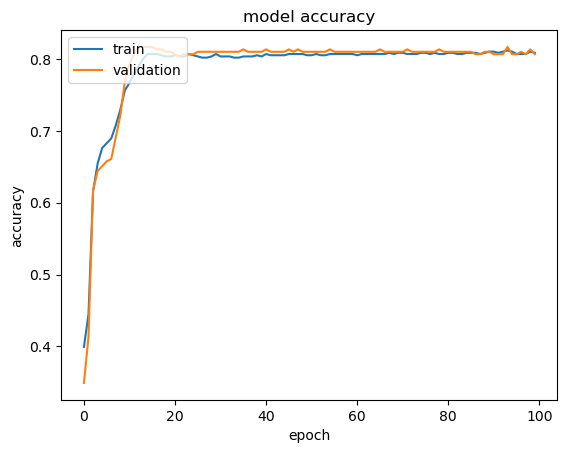

In [36]:
# summarize history for accuracy
plt.plot(training.history['accuracy'], label='train')
plt.plot(training.history['val_accuracy'], label = 'validation')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()

In [37]:
# create model
model = KerasClassifier(build_fn=create_model, verbose=0)

# define the grid search parameters
batch_size = [16, 32, 64]
epochs = [50, 100]
param_grid = dict(batch_size=batch_size, epochs=epochs)

# search the grid
grid = GridSearchCV(estimator=model, 
                    param_grid=param_grid,
                    cv=3,
                    verbose=2)  # include n_jobs=-1 if you are using CPU

grid_result = grid.fit(X_train, y_train)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  


Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] END ...........................batch_size=16, epochs=50; total time=   3.7s
[CV] END ...........................batch_size=16, epochs=50; total time=   3.7s
[CV] END ...........................batch_size=16, epochs=50; total time=   3.3s
[CV] END ..........................batch_size=16, epochs=100; total time=   6.5s
[CV] END ..........................batch_size=16, epochs=100; total time=   5.6s
[CV] END ..........................batch_size=16, epochs=100; total time=   6.2s
[CV] END ...........................batch_size=32, epochs=50; total time=   2.5s
[CV] END ...........................batch_size=32, epochs=50; total time=   3.7s
[CV] END ...........................batch_size=32, epochs=50; total time=   2.4s
[CV] END ..........................batch_size=32, epochs=100; total time=   3.6s
[CV] END ..........................batch_size=32, epochs=100; total time=   6.2s
[CV] END ..........................batch_size=32,

In [38]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.815475 using {'batch_size': 16, 'epochs': 100}
0.797015 (0.020742) with: {'batch_size': 16, 'epochs': 50}
0.815475 (0.018159) with: {'batch_size': 16, 'epochs': 100}
0.783590 (0.028196) with: {'batch_size': 32, 'epochs': 50}
0.798690 (0.021432) with: {'batch_size': 32, 'epochs': 100}
0.786931 (0.031749) with: {'batch_size': 64, 'epochs': 50}
0.802066 (0.026364) with: {'batch_size': 64, 'epochs': 100}


In [39]:
# create model
model = KerasClassifier(build_fn=create_model, epochs=50, batch_size=32, verbose=0)

# define the grid search parameters
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Nadam']
param_grid = dict(opt=optimizer)

# search the grid
grid = GridSearchCV(estimator=model, param_grid=param_grid, verbose=2)
grid_result = grid.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  


[CV] END ............................................opt=SGD; total time=   3.5s
[CV] END ............................................opt=SGD; total time=   3.5s
[CV] END ............................................opt=SGD; total time=   2.4s
[CV] END ............................................opt=SGD; total time=   3.5s
[CV] END ............................................opt=SGD; total time=   3.5s
[CV] END ........................................opt=RMSprop; total time=   2.3s
[CV] END ........................................opt=RMSprop; total time=   2.6s
[CV] END ........................................opt=RMSprop; total time=   2.4s
[CV] END ........................................opt=RMSprop; total time=   2.6s
[CV] END ........................................opt=RMSprop; total time=   2.4s
[CV] END ........................................opt=Adagrad; total time=   2.3s
[CV] END ........................................opt=Adagrad; total time=   2.3s
[CV] END ...................

In [40]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.798711 using {'opt': 'Nadam'}
0.788641 (0.039951) with: {'opt': 'SGD'}
0.793683 (0.046503) with: {'opt': 'RMSprop'}
0.466625 (0.113761) with: {'opt': 'Adagrad'}
0.553782 (0.105776) with: {'opt': 'Adadelta'}
0.795350 (0.046873) with: {'opt': 'Adam'}
0.798711 (0.042547) with: {'opt': 'Nadam'}


In [41]:
seed(42)
tf.random.set_seed(42)

# create model
model = KerasClassifier(build_fn=create_model, 
                        epochs=50, batch_size=32, verbose=0)

# define the grid search parameters
layers = [[8],[10],[10,5],[12,6],[12,8,4]]
param_grid = dict(lyrs=layers)

# search the grid
grid = GridSearchCV(estimator=model, param_grid=param_grid, verbose=2)
grid_result = grid.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  


[CV] END ...........................................lyrs=[8]; total time=   2.5s
[CV] END ...........................................lyrs=[8]; total time=   2.5s
[CV] END ...........................................lyrs=[8]; total time=   3.3s
[CV] END ...........................................lyrs=[8]; total time=   2.7s
[CV] END ...........................................lyrs=[8]; total time=   2.5s
[CV] END ..........................................lyrs=[10]; total time=   2.7s
[CV] END ..........................................lyrs=[10]; total time=   2.5s
[CV] END ..........................................lyrs=[10]; total time=   3.7s
[CV] END ..........................................lyrs=[10]; total time=   3.7s
[CV] END ..........................................lyrs=[10]; total time=   2.7s
[CV] END .......................................lyrs=[10, 5]; total time=   3.8s
[CV] END .......................................lyrs=[10, 5]; total time=   2.8s
[CV] END ...................

In [42]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.805434 using {'lyrs': [12, 6]}
0.798711 (0.041198) with: {'lyrs': [8]}
0.798711 (0.042547) with: {'lyrs': [10]}
0.798725 (0.045352) with: {'lyrs': [10, 5]}
0.805434 (0.044878) with: {'lyrs': [12, 6]}
0.803768 (0.044552) with: {'lyrs': [12, 8, 4]}


In [43]:
# create model
model = KerasClassifier(build_fn=create_model, 
                        epochs=50, batch_size=32, verbose=0)

# define the grid search parameters
drops = [0.0, 0.01, 0.05, 0.1, 0.2, 0.5]
param_grid = dict(dr=drops)
grid = GridSearchCV(estimator=model, param_grid=param_grid, verbose=2)
grid_result = grid.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  This is separate from the ipykernel package so we can avoid doing imports until


[CV] END .............................................dr=0.0; total time=   3.7s
[CV] END .............................................dr=0.0; total time=   2.5s
[CV] END .............................................dr=0.0; total time=   2.6s
[CV] END .............................................dr=0.0; total time=   2.5s
[CV] END .............................................dr=0.0; total time=   3.6s
[CV] END ............................................dr=0.01; total time=   2.6s
[CV] END ............................................dr=0.01; total time=   2.7s
[CV] END ............................................dr=0.01; total time=   3.7s
[CV] END ............................................dr=0.01; total time=   4.5s
[CV] END ............................................dr=0.01; total time=   2.7s
[CV] END ............................................dr=0.05; total time=   3.8s
[CV] END ............................................dr=0.05; total time=   2.7s
[CV] END ...................

In [44]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.800364 using {'dr': 0.05}
0.798711 (0.039087) with: {'dr': 0.0}
0.797031 (0.044636) with: {'dr': 0.01}
0.800364 (0.042830) with: {'dr': 0.05}
0.797045 (0.043911) with: {'dr': 0.1}
0.795322 (0.039868) with: {'dr': 0.2}
0.790294 (0.036656) with: {'dr': 0.5}


In [48]:
# create final model
model = create_model(lyrs=[12, 6], dr=0.05, opt='Nadam')

print(model.summary())

# train model on full train set, with 80/20 CV split
training = model.fit(X_train, y_train, epochs=100, batch_size=16, 
                     validation_data=(X_test, y_test), verbose=0)

# evaluate the model
scores = model.evaluate(X_train, y_train)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

Model: "sequential_109"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_239 (Dense)           (None, 12)                120       
                                                                 
 dense_240 (Dense)           (None, 6)                 78        
                                                                 
 dropout_109 (Dropout)       (None, 6)                 0         
                                                                 
 dense_241 (Dense)           (None, 1)                 7         
                                                                 
Total params: 205
Trainable params: 205
Non-trainable params: 0
_________________________________________________________________
None
19/19 [==============================] - 0s 2ms/step - loss: 0.4320 - accuracy: 0.8272

accuracy: 82.72%


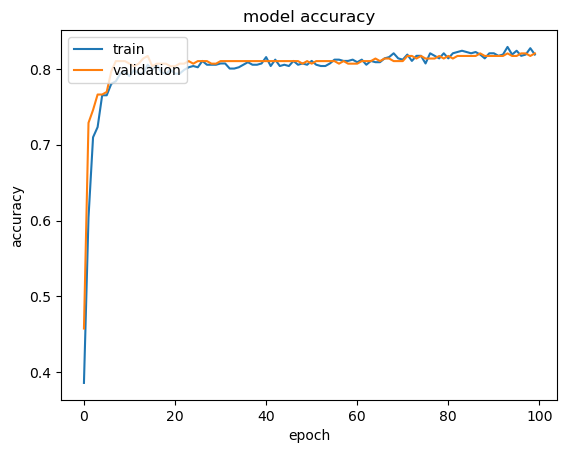

In [49]:
# summarize history for accuracy
plt.plot(training.history['accuracy'])
plt.plot(training.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# FINAL SUBMISSION

In [47]:
"""output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")"""

'output = pd.DataFrame({\'PassengerId\': test_data.PassengerId, \'Survived\': predictions})\noutput.to_csv(\'submission.csv\', index=False)\nprint("Your submission was successfully saved!")'